Having completed the course "Machine Learning Specialization" by deeplearning.ai, I am at the exciting point where I can put the theory into practice by applying it in a project with real-world data.

As someone interested in sustainability and thinking about how to reduce our impact as a society, energy production and consumption has been a hot topic both scientifically as politically. A recurring theme is the impact of wind and solar energy on the stability of the electricity grid (https://www.creg.be/sites/default/files/assets/Publications/Studies/F2866NL.pdf) and the compatibility of renewable energy sources (e.g. wind and solar) and nuclear energy. In order to, on the one hand, plan out a policy and, on the other hand, keep a stable day-to-day grid, it is necessary to have a correct prediction of our energy consumption (in this case Belgium). It thus looks like an excellent opportunity to see how the approaches I have learned, could aid in improving these predictions. The exciting part is also that this is an active field of study (by grid operators such as Elia for example) with an immediate real-world impact. Let us take a shot at it. 

In this notebook, we will predict quarterhourly energy consumption (the total load) in Belgium by training it on historical data by ENTSO-E (European Network of Transmission System Operators for Electricity). The historical data can be retrieved from their transparency platform (https://transparency.entsoe.eu/dashboard/show). Interestingly, they also provide their own predictions which can serve as a benchmark for our models.

First, we will explore the data, which models do well and optimize their parameters on a restricted data set. Indeed, we downloaded the dataset for the quarterhourly energy consumption in Belgium ranging from 01.01.2025 to 22.10.2025 in the form of a CSV file.

In [ ]:
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV data file; contains header as first row; three columns: interval, forecast, actual; missing values are indicated by '-'
df = pd.read_csv("data/Total Load - Day Ahead _ Actual_202501010000-202601010000.csv", header=0, names=['interval', 'forecast', 'actual'], na_values='-')
# Inspect
print(df.head())
print("Shape of the raw input data:", df.shape)


                              interval  forecast  actual
0  01.01.2025 00:00 - 01.01.2025 00:15    8778.0  8234.0
1  01.01.2025 00:15 - 01.01.2025 00:30    8647.0  8127.0
2  01.01.2025 00:30 - 01.01.2025 00:45    8502.0  8057.0
3  01.01.2025 00:45 - 01.01.2025 01:00    8389.0  7963.0
4  01.01.2025 01:00 - 01.01.2025 01:15    8318.0  7886.0
Shape of the raw input data: (35044, 3)


We observe that the hourly consumption is monitored per 15 minute interval. We prepare the data by deriving separate date and time features, and removing the empty data slots (corresponding to dates in the future, that is, past 22.10.2025).

In [118]:
# Convert the start time to datetime
df['start_time'] = pd.to_datetime(df['interval'].str.split(' - ').str[0], format="%d.%m.%Y %H:%M")
df['end_time'] = pd.to_datetime(df['interval'].str.split(' - ').str[1], format="%d.%m.%Y %H:%M")

# Convert time to day, month, year, hour, minute
df['day'] = df['start_time'].dt.day #maybe redundant with dayofweek
df['dayofweek'] = df['start_time'].dt.dayofweek
df['month'] = df['start_time'].dt.month
df['year'] = df['start_time'].dt.year
df['hour'] = df['start_time'].dt.hour
df['quarter'] = df['start_time'].dt.minute // 15 #may be redundant with hour, overfitting?

# Remove rows where either forecast or actual is NaN
print("Number of missing rows actual:", df[['actual']].isna().sum())
df = df.dropna(subset=['actual'])


Number of missing rows actual: actual    6866
dtype: int64


Let us plot this data to get a bit of an overview.

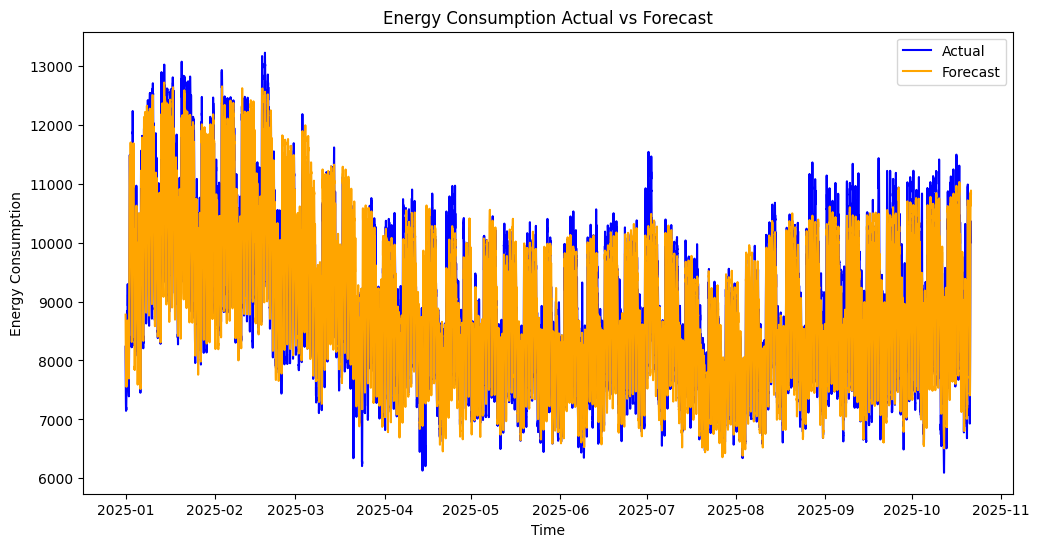

In [119]:
# plot the actual vs forecasted energy consumption for the first week
plt.figure(figsize=(12, 6))
plt.plot(df['start_time'], df['actual'], label='Actual', color='blue')
plt.plot(df['end_time'], df['forecast'], label='Forecast', color='orange')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption Actual vs Forecast')
plt.legend()
plt.show()

We thus obtain a labelled data set on which we can perform supervised ML. 

The most naive model would be linear regression, however from the data above it is clear that the data is highly fluctuating. A simple line would be an even too naive approach to start from. For our first attempt, let us fit a polynomial of high degree (let's say 5). 

From the plot and thinking about the problem, we have the following observations
- there seems to be a waive within the continuous time line. We can add this as an extra feature to account for this trend.
- we keep the month, day, hour, quarter as separate features as we expect them each to encode a different trend
- thinking about energy consumption, one would expect there to be a correlation (and thus predictive value) between the weekday and the hour (week or weekend patterns). So, we add this combined feature.
- if it gets computationally hard, perhaps hourly instead of quarterhourly data points suffice

We thus are engineering the features by considering higher order and combined features.

In [120]:
# time index numbering (with integers) each quarter hour from start to end
df['time_index'] = np.arange(len(df))

# add combine features: weekday and hour
df['weekday_hour'] = df['dayofweek'] * 24 + df['hour']

# input matrix
X = df[['day', 'dayofweek', 'month', 'year', 'hour', 'quarter', 'time_index', 'weekday_hour']].values
y = df['actual'].values

# higher features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly.fit_transform(X)


As the numerical min and max of each feature very highly, we normalize them.

In [ ]:
# normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_poly_scaled = scaler.fit_transform(X_poly)

# normalized target (flatten converts it back to a 1D array)
y_scaler = StandardScaler() 
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
# dont forget to inverse transform when predicting!

We also prepare our by splitting it chronologically into a training set, a cross validation set and a test set. The cross validation set will be used to optimize the regularization parameter in our regression model.

In [127]:
#  Divide into test, cross-validation, and training sets in chronological order 
num_samples = X_poly.shape[0]
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

X_poly_scaled_train, X_poly_scaled_val, X_poly_scaled_test = X_poly_scaled[:train_size], X_poly_scaled[train_size:train_size + val_size], X_poly_scaled[train_size + val_size:]
y_scaled_train, y_scaled_val, y_scaled_test = y_scaled[:train_size], y_scaled[train_size:train_size + val_size], y_scaled[train_size + val_size:]
print("Training set size:", X_poly_scaled_train.shape[0])
print("Validation set size:", X_poly_scaled_val.shape[0])
print("Test set size:", X_poly_scaled_test.shape[0])
print("Y train size:", y_scaled_train.shape[0])
print("Y val size:", y_scaled_val.shape[0])
print("Y test size:", y_scaled_test.shape[0])

Training set size: 19724
Validation set size: 4226
Test set size: 4228
Y train size: 19724
Y val size: 4226
Y test size: 4228


We apply the linear regression model with a regularization parameter lambda = 0.01

Epoch 1/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 49.1098 - val_loss: 0.6767
Epoch 2/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4899 - val_loss: 0.4644
Epoch 3/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4406 - val_loss: 0.3845
Epoch 4/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4359 - val_loss: 0.4613
Epoch 5/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4683 - val_loss: 0.5572
Epoch 6/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5374 - val_loss: 0.3994
Epoch 7/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6548 - val_loss: 0.4648
Epoch 8/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9198 - val_loss: 0.5268
Epoch 9/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9190 - val_loss: 1.8975
Epoch 10/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8569 - val_loss: 0.4309
Epoch 11/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8130 - val_loss: 1.8498
Epoch 12/50
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/ste

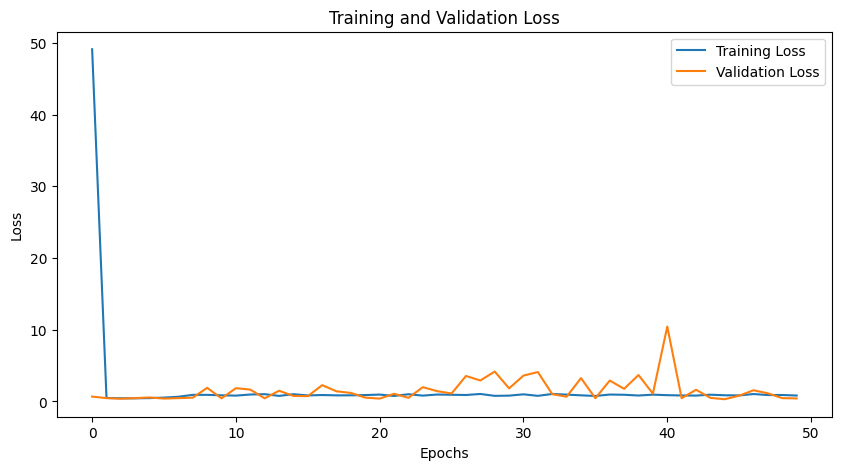

In [ ]:
# linear regression model 
model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(X_poly_scaled_train.shape[1],),
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))
    ])
    
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')
    
# Train model (use validation data)
history = model.fit(X_poly_scaled_train, y_scaled_train,
                    epochs=50,
                    validation_data=(X_poly_scaled_val, y_scaled_val),
                    verbose=1)  # no silent training

# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Scaled Training Loss')
plt.plot(history.history['val_loss'], label='Scaled Validation Loss')
plt.title('Scaled Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We clearly notice that both the validation and the loss go down very quickly and then stagnate, with the validation error acting rather erratic towards the end.
Perhaps, we can slightly improve on this by tweaking the regularization parameter. However, it is clear that we can decrease to the number of iterations to get to a similar loss.

Trained with lambda=0.0, Validation Loss=0.6930225491523743
Trained with lambda=0.001, Validation Loss=0.9869453310966492
Trained with lambda=0.01, Validation Loss=0.767996072769165
Trained with lambda=0.1, Validation Loss=0.9470658898353577
Trained with lambda=1.0, Validation Loss=0.6509574055671692
Best L2 regularization: 1.0


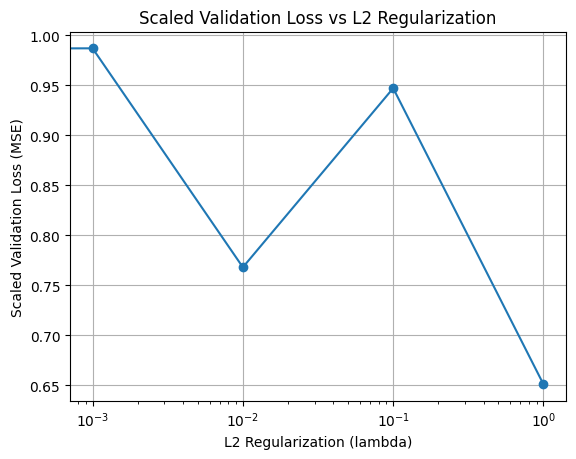

In [131]:
# linear regression model with regularization parameter lambda

# Candidate L2 regularization values
lambdas = [0.0, 0.001, 0.01, 0.1, 1.0]
val_losses = []

for l in lambdas:
    # Build model with L2 regularization
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(X_poly_scaled_train.shape[1],),
                              kernel_regularizer=tf.keras.regularizers.l2(l))
    ])
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model (use validation data)
    history = model.fit(X_poly_scaled_train, y_scaled_train,
                        epochs=20,
                        validation_data=(X_poly_scaled_val, y_scaled_val),
                        verbose=0)  # silent training
    
    # Record final validation loss
    val_losses.append(history.history['val_loss'][-1])
    # Print progress
    print(f"Trained with lambda={l}, Validation Loss={history.history['val_loss'][-1]}")

# Find the best lambda
best_idx = np.argmin(val_losses)
best_lambda = lambdas[best_idx]
print("Best L2 regularization:", best_lambda)

#plot validation losses vs lambdas
plt.figure()
plt.plot(lambdas, val_losses, marker='o')
plt.xscale('log')
plt.xlabel('L2 Regularization (lambda)')
plt.ylabel('Scaled Validation Loss (MSE)')
plt.title('Scaled Validation Loss vs L2 Regularization')
plt.grid()
plt.show()



Let us now use this best lamda and calculate a relevant error measure for forecasting MAPE (= Mean Absolute Percentage Error). We compare this with the MAPE of the forecasts by ENTSO-E itself.

In [146]:
# MAPE for training, validation and test set with best lambda
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(X_poly_scaled_train.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(best_lambda))
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model (use validation data)
history = model.fit(X_poly_scaled_train, y_scaled_train,
                    epochs=20,
                    validation_data=(X_poly_scaled_val, y_scaled_val),
                    verbose=0)  # silent training

# Calculate MAPE for training, validation and test sets
y_scaled_train_pred = model.predict(X_poly_scaled_train)
y_scaled_val_pred = model.predict(X_poly_scaled_val)
y_scaled_test_pred = model.predict(X_poly_scaled_test)




e:\My Drive\Wiskunde\AI\Projects\pet_projects\energy_forecasting\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


In [147]:
# MAPE for ENTSO-E forecast on train, val and test sets
y_forecast = df['forecast'].values
y_forecast_train, y_forecast_val, y_forecast_test = y_forecast[:train_size], y_forecast[train_size:train_size + val_size], y_forecast[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

mape_forecast_train = np.mean(np.abs((y_train - y_forecast_train) / y_train)) * 100
mape_forecast_val = np.mean(np.abs((y_val - y_forecast_val) / y_val)) * 100
mape_forecast_test = np.mean(np.abs((y_test - y_forecast_test) / y_test)) * 100

print("MAPE for ENTSO-E Forecast on Training Set:", mape_forecast_train)
print("MAPE for ENTSO-E Forecast on Validation Set:", mape_forecast_val)
print("MAPE for ENTSO-E Forecast on Test Set:", mape_forecast_test)

# unscale y_train, y_val, y_test and their predictions
y_train_pred = y_scaler.inverse_transform(y_scaled_train_pred.reshape(-1, 1)).flatten()
y_val_pred = y_scaler.inverse_transform(y_scaled_val_pred.reshape(-1, 1)).flatten()
y_test_pred = y_scaler.inverse_transform(y_scaled_test_pred.reshape(-1, 1)).flatten()

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_val = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("MAPE for Training Set:", mape_train)
print("MAPE for Validation Set:", mape_val)
print("MAPE for Test Set:", mape_test)

MAPE for ENTSO-E Forecast on Training Set: 2.9258038452118917
MAPE for ENTSO-E Forecast on Validation Set: 2.2857908980094885
MAPE for ENTSO-E Forecast on Test Set: 2.7097763617503636
MAPE for Training Set: 7.664800929807147
MAPE for Validation Set: 9.08202820021585
MAPE for Test Set: 11.875844711683174


The MAPE for our model turns out to be rather large, especially in comparison with the ENTSO-E predictions.

Looking at the original plot of data, it is clear that the target value is periodic with respect to the time features and, as a mathematician or physicist, one would rather try approximating the frequenties and amplitudes of this curve. 

For a quick review: the basic equation is given by y = A sin(fx) + B cos (fx). Here, f represents the frequencies and A,B the amplitudes of each. Using both sin and cos provides us with a complete description of the point on the circle (thus also capturing the phase shift).

As a starting point, we can assumme the frequencies are determined by the feature itself: for example the day feature has a period of length 7, so its corresponding frequence is 1/7, and so on.
Possibly, we could aim at approximating more refined subfrequencies (similar to how Fourier transforms work), but let us see how far we get without.
-> the cyclic features are: month, day, day of the week, hour, quarter

The model itself will be approximating the amplitudes.



In [148]:
# frequency of month of year
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# frequency of day of month
df['dom_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['dom_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# frequency of day of week
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# frequency of hour of day
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# frequency of quarter of hour
df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

# frequency of weekday_hour - skip this for now for computational reasons
#df['weekday_hour_sin'] = np.sin(2 * np.pi * df['weekday_hour'] / 168)
#df['weekday_hour_cos'] = np.cos(2 * np.pi * df['weekday_hour'] / 168)

# New input matrix with engineered features
X_sincos = df[['year', 'time_index', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'dom_sin', 'dom_cos']].values

# normalize features time index, year
scaler_sincos = StandardScaler() 
X_sincos_scaled = X_sincos.copy()
X_sincos_scaled[:, [0, 1]] = scaler_sincos.fit_transform(X_sincos[:, [0, 1]])


Let us now retrain with regularization paramater lambda = 0.1. 

Epoch 1/20


e:\My Drive\Wiskunde\AI\Projects\pet_projects\energy_forecasting\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0630
Epoch 2/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5225
Epoch 3/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4456
Epoch 4/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4311
Epoch 5/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4266
Epoch 6/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4249
Epoch 7/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4245
Epoch 8/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4243
Epoch 9/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4242
Epoch 10/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4242
Epoch 11/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4242
Epoch 12/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4242
Epoch 13/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4241
Epoch 14/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4241
Epoch 15/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4242


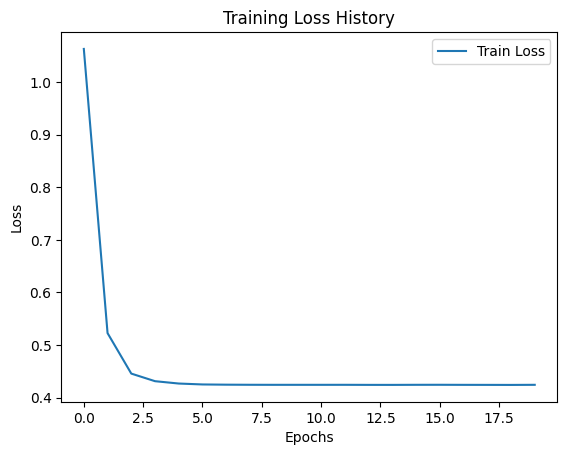

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MAPE for Training Set: 6.791612610985188
MAPE for Validation Set: 6.701764158954749
MAPE for Test Set: 7.137972625543992


In [150]:
# split X_sincos into train, val, test
X_sincos_scaled_train, X_sincos_scaled_val, X_sincos_scaled_test = X_sincos_scaled[:train_size], X_sincos_scaled[train_size:train_size + val_size], X_sincos_scaled[train_size + val_size:]    

# linear model with reg param = 0.01
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(X_sincos_scaled_train.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(0.1))
])
model.compile(optimizer='adam', loss='mean_squared_error')

# split y_scaled into train, val, test
y_scaled_train, y_scaled_val, y_scaled_test = y_scaled[:train_size], y_scaled[train_size:train_size + val_size], y_scaled[train_size + val_size:]

# train model and show progress bar
history = model.fit(X_sincos_scaled_train, y_scaled_train, epochs=20, verbose=1)

# plot history of training loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()

# MAPE for training, validation and test set with sincos features
y_scaled_train_pred = model.predict(X_sincos_scaled_train)
y_scaled_val_pred = model.predict(X_sincos_scaled_val)
y_scaled_test_pred = model.predict(X_sincos_scaled_test)

# unscale y_train, y_val, y_test and their predictions
y_train_pred = y_scaler.inverse_transform(y_scaled_train_pred.reshape(-1, 1)).flatten()
y_val_pred = y_scaler.inverse_transform(y_scaled_val_pred.reshape(-1, 1)).flatten()
y_test_pred = y_scaler.inverse_transform(y_scaled_test_pred.reshape(-1, 1)).flatten()

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_val = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("MAPE for Training Set:", mape_train)
print("MAPE for Validation Set:", mape_val)
print("MAPE for Test Set:", mape_test)


This shows that the MAPE on all three sets is significantly improved ending up wit 7.1% on the test set. However, this does not yet come close to the ENTSO-E MAPE of 2,9%. 

Comparing the training, validation and test MAPE with their ENTSO-E counterparts, we are in the situation where we have both high bias and high variance.




Let us muze on how this could be improved:
- more data: currently it is only trained on the data of a single year. Yearly trends such as seasons thus are not very pronounced in this data.
- more relevant features: clearly weather plays an important role which has not been taken into account. Possibly also: holidays, special recurring events,...
- non linear relationships between features and target: although periodicity of certain features is accounter for, the model currently only approximates their amplitudes in a linear way. Other frequencies representing multiple periodic patterns are possible.
- - consider adding higher features and play with reg parameter.
- more back-in-time dependency: the consumption of the past month likely has a good predictive value for the upcoming month 

In order to keep it computationally manageable, let us focus on the second and third option. For fun's sake, let us look into non-linear models to lower the bias. 

We have two different options for non-linear approaches: decision trees and neural networks (NN). As we are working with structured data and NN are computationally heavy, let us try the first.

For this decision tree, we have both 
- a continuous target
- continuous features: year, month_sin/cos, day_sin/cos, dayofweek_sin/cos, hour_sin/cos, quarter_sin/cos, time_index, weekday_sin/cos
Although these are not binary features, trees will be able to handle them by looking for an optimal splitting, that is, obtaining a piecewise-constant approximation. Each tree on its own is rather crude for this regression problem, but a random forest is a summation of a large number of these thus approximating our continuous nonlinear regression problem.

In particular, XGBoost is known to be extremely fast and effective. Observe that in this case, there is no need normalize the inputs (decision trees work with orders instead of distances), nor feature engineer the periodicity (it might smoothen the loss function, but it won't make a big difference).



In [151]:
import xgboost as xgb

# reinitialize our input matrices
X = df[['day', 'dayofweek', 'month', 'year', 'hour', 'quarter', 'time_index', 'dayofweek']].values
y= df[['actual']].values.flatten()

# divide into train, val, test
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:] 



In [152]:
import xgboost as xgb

# XGBoost model for non-linear approach
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100,
                                learning_rate=0.1,
                                max_depth=6,
                                subsample=0.8,
                                eval_metric='rmse',
                                colsample_bytree=0.8,
                                random_state=42)
history = xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Evaluate on val set
val_loss_xgb = xgb_model.score(X_val, y_val)
print("XGBoost Val R^2:", val_loss_xgb)

# MAPE on val set
y_val_pred = xgb_model.predict(X_val)
mape_xgb = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
print("XGBoost Val MAPE:", mape_xgb)

[0]	validation_0-rmse:1226.40359
[1]	validation_0-rmse:1134.61865
[2]	validation_0-rmse:1054.82770
[3]	validation_0-rmse:996.85548
[4]	validation_0-rmse:944.59489
[5]	validation_0-rmse:922.30469
[6]	validation_0-rmse:872.94715
[7]	validation_0-rmse:857.44832
[8]	validation_0-rmse:825.25139
[9]	validation_0-rmse:802.21761
[10]	validation_0-rmse:772.64333
[11]	validation_0-rmse:747.98977
[12]	validation_0-rmse:731.87820
[13]	validation_0-rmse:719.64153
[14]	validation_0-rmse:718.34479
[15]	validation_0-rmse:699.97330
[16]	validation_0-rmse:689.37773
[17]	validation_0-rmse:693.46919
[18]	validation_0-rmse:698.19558
[19]	validation_0-rmse:702.75331
[20]	validation_0-rmse:707.06319
[21]	validation_0-rmse:712.26190
[22]	validation_0-rmse:717.94544
[23]	validation_0-rmse:718.66836
[24]	validation_0-rmse:715.38198
[25]	validation_0-rmse:718.09979
[26]	validation_0-rmse:715.86717
[27]	validation_0-rmse:714.72940
[28]	validation_0-rmse:713.30395
[29]	validation_0-rmse:719.61442
[30]	validation_0

As we can see, XGBoost is a very efficient and effective algorithm for this regression problem. Let us tweak the hyperparameters in order to hopefully improve our result. 

Let us optimize the key ones: the number of estimators (= how many trees), maximum depth of each tree and learning rate.

In [154]:
# Optimize max_depth, n_estimators, learning rate using grid search with cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=3), verbose=1)
grid_search.fit(X, y)

print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


The gridsearch shows the best parameters found were learning rate = 0.1, max_depth = 5 and n_estimators = 50. This might be counterintuitive as the deeper the trees and the more trees, the lower the error. Yet, the model then turns out to be overfitted, which in turn favours less depth and thiner forests.


Let us now verify how far we have gotten.

In [155]:
# XGBoost model for non-linear approach
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=50,
                                learning_rate=0.1,
                                max_depth=5,
                                subsample=0.8,
                                eval_metric='rmse',
                                colsample_bytree=0.8,
                                random_state=42)
history = xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Evaluate on val set
val_loss_xgb = xgb_model.score(X_val, y_val)
print("XGBoost Val R^2:", val_loss_xgb)

# MAPE on training set
y_train_pred = xgb_model.predict(X_train)
mape_xgb_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print("XGBoost Train MAPE:", mape_xgb_train)

# MAPE on val set
y_val_pred = xgb_model.predict(X_val)
mape_xgb = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
print("XGBoost Val MAPE:", mape_xgb)

# MAPE on test set
y_test_pred = xgb_model.predict(X_test)
mape_xgb_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print("XGBoost Test MAPE:", mape_xgb_test)

[0]	validation_0-rmse:1220.06862
[1]	validation_0-rmse:1131.10327
[2]	validation_0-rmse:1054.28546
[3]	validation_0-rmse:998.31383
[4]	validation_0-rmse:938.68897
[5]	validation_0-rmse:918.31890
[6]	validation_0-rmse:865.64688


[7]	validation_0-rmse:849.25411
[8]	validation_0-rmse:820.99977
[9]	validation_0-rmse:791.98009
[10]	validation_0-rmse:761.49641
[11]	validation_0-rmse:733.34868
[12]	validation_0-rmse:711.81455
[13]	validation_0-rmse:693.36913
[14]	validation_0-rmse:692.83662
[15]	validation_0-rmse:694.41183
[16]	validation_0-rmse:680.78772
[17]	validation_0-rmse:670.72549
[18]	validation_0-rmse:676.19214
[19]	validation_0-rmse:674.17089
[20]	validation_0-rmse:676.83477
[21]	validation_0-rmse:687.04628
[22]	validation_0-rmse:699.75216
[23]	validation_0-rmse:698.87575
[24]	validation_0-rmse:693.35944
[25]	validation_0-rmse:698.06022
[26]	validation_0-rmse:694.27089
[27]	validation_0-rmse:692.71364
[28]	validation_0-rmse:694.16635
[29]	validation_0-rmse:696.15441
[30]	validation_0-rmse:705.26819
[31]	validation_0-rmse:715.27690
[32]	validation_0-rmse:711.15907
[33]	validation_0-rmse:709.40816
[34]	validation_0-rmse:707.95669
[35]	validation_0-rmse:704.14904
[36]	validation_0-rmse:703.60037
[37]	validati

This shows that XGBoost is able to very well fit the data (2.4%), but it has high variance as on the val set we only reach 6.1% and on the test set we end up at 9.3% error. It is interesting to notice that in comparison with the linear regression model, we arrive at far better data fit, but similar variance and worse test error (in the previous model, the val set = test set). 



Let us now see how neural networks do for this regression problem. Observe, here normalizing is important again. 

In [157]:
# normalize input matrix X
scaler_nn = StandardScaler() 
X_scaled = scaler_nn.fit_transform(X)

# split X_scaled into train, val, test
X_scaled_train, X_scaled_val, X_scaled_test = X_scaled[:train_size], X_scaled[train_size:train_size + val_size], X_scaled[train_size + val_size:]



# neural network model
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_scaled_train.shape[1],)),
    tf.keras.layers.Dropout(0.2), # prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model_nn.compile(optimizer='adam', loss='mean_squared_error')

history_nn = model_nn.fit(X_scaled_train, y_scaled_train, validation_data=(X_scaled_val, y_scaled_val), epochs=100, batch_size=32, verbose=1)

# Evaluate on val set
val_loss_nn = model_nn.evaluate(X_scaled_val, y_scaled_val)
print("Neural Network Val Loss:", val_loss_nn)

# MAPE on training set
y_train__scaled_pred_nn = model_nn.predict(X_scaled_train)
y_train_pred_nn = y_scaler.inverse_transform(y_train__scaled_pred_nn.reshape(-1, 1)).flatten()
mape_nn_train = np.mean(np.abs((y_train - y_train_pred_nn) / y_train)) * 100
print("Neural Network Train MAPE:", mape_nn_train)

# MAPE on val set
y_val_pred_nn = model_nn.predict(X_scaled_val)
y_val_pred_nn = y_scaler.inverse_transform(y_val_pred_nn.reshape(-1, 1)).flatten()
mape_nn = np.mean(np.abs((y_val - y_val_pred_nn) / y_val)) * 100
print("Neural Network Val MAPE:", mape_nn)

# MAPE on test set
y_test_pred_nn = model_nn.predict(X_scaled_test)
y_test_pred_nn = y_scaler.inverse_transform(y_test_pred_nn.reshape(-1, 1)).flatten()
mape_nn_test = np.mean(np.abs((y_test - y_test_pred_nn) / y_test)) * 100
print("Neural Network Test MAPE:", mape_nn_test)

Epoch 1/100


e:\My Drive\Wiskunde\AI\Projects\pet_projects\energy_forecasting\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3657 - val_loss: 0.2215
Epoch 2/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2484 - val_loss: 0.2360
Epoch 3/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2115 - val_loss: 0.2393
Epoch 4/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1876 - val_loss: 0.2365
Epoch 5/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1690 - val_loss: 0.2875
Epoch 6/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1540 - val_loss: 0.3037
Epoch 7/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1395 - val_loss: 0.3309
Epoch 8/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1292 - val_loss: 0.3452
Epoch 9/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1211 - val_loss: 0.3237
Epoch 10/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1138 - val_loss: 0.4064
Epoch 11/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1119 - val_loss: 0.3974
Epoch 12/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

A relatively short training of 2 min 30 sec has resulted in a comparible scenario to the trees: low bias error (2% on train set), high variance (7.5% on val set) and high test error (13.5%). 

The theory tells us: the next step to do is to add more data. This is definitely doable given the public available data, but requires a stronger CPU/GPU, so we leave this for another time.

 An interesting solution would be to look for a large pretrained NN and use it as a base via transfer learning. This is also an interesting avenue (together with more data which is luckily available) for future improvements.

We thus have provided three models for this regression problem using supervised ML. It seems that thus far decision trees and XGBoost have provided the most satisfactory solution: equally as effective as linear modelling, but more scalable for a larger data set. Let us implement this with an extraction method for a large amount of historical data spanning multiple years in a separate file.